In [1]:
import sys
path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)
import ising

import os
os.chdir("/Users/mariusmahiout/Documents/repos/ising_core/python")
import src.misc_plotting as plotting
import src.utils as utils
import src.model_eval as eval
import src.isingfitter as fitter
import src.sampler_analytic as anal

import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [44]:
import pandas as pd
from tqdm import tqdm

In [21]:
num_units = 100
beta = 10
num_sims = 15_000
num_burn = 1000

In [65]:
def get_emp_vs_analytic_rmses(num_units: int, beta: float, num_sims: int, num_burn: int):
    pairs = anal.get_indep_pairs(num_units)
    model = anal.get_ip_model(num_units, pairs, beta)
    emp_obs = anal.get_empirical_ip_obs(model, num_sims, num_burn)
    anal_obs = anal.get_analytic_ip_obs(model.getFields(), model.getCouplings(), pairs)

    rmse_m = utils.get_rmse(anal_obs["m"], emp_obs["m"])
    rmse_chi = utils.get_rmse(anal_obs["chi"], emp_obs["chi"])

    return rmse_m, rmse_chi

def get_sampler_rmses_num_units(min_units: int=3, max_units: int=200, beta: float=1.3, num_sims: int=15_000, num_burn: int=1000, num_epochs: int=10):
    rmses_means = dict((epoch, []) for epoch in range(num_epochs))
    rmses_pcorrs = dict((epoch, []) for epoch in range(num_epochs))

    for epoch in tqdm(range(num_epochs)):
        for num_units in range(min_units, max_units+1):
            rmse_m, rmse_chi = get_emp_vs_analytic_rmses(num_units, beta, num_sims, num_burn)

            rmses_means[epoch].append(rmse_m)
            rmses_pcorrs[epoch].append(rmse_chi)

    rmses_means = pd.DataFrame(rmses_means)
    rmses_pcorrs = pd.DataFrame(rmses_pcorrs)
    return rmses_means, rmses_pcorrs

def get_sampler_rmses_beta(beta_min: int=0.1, beta_max: int=10, num_units: int=20, num_sims: int=15_000, num_burn: int=1000, num_epochs: int=10):
    rmses_means = dict((epoch, []) for epoch in range(num_epochs))
    rmses_pcorrs = dict((epoch, []) for epoch in range(num_epochs))

    for epoch in tqdm(range(num_epochs)):
        for beta in np.linspace(beta_min, beta_max, 100):
            rmse_m, rmse_chi = get_emp_vs_analytic_rmses(num_units, beta, num_sims, num_burn)

            rmses_means[epoch].append(rmse_m)
            rmses_pcorrs[epoch].append(rmse_chi)

    rmses_means = pd.DataFrame(rmses_means)
    rmses_pcorrs = pd.DataFrame(rmses_pcorrs)
    return rmses_means, rmses_pcorrs

def integer_iterator(int_min, int_max, num_ints=100):
    linspace_floats = np.linspace(int_min, int_max, num_ints)
    integers = np.round(linspace_floats).astype(int)
    return iter(integers)

def get_sampler_rmses_num_sims(sims_min: int=1000, sims_max: int=100_000, num_units: int=20, beta: float=1.3, num_burn: int=1000, num_epochs: int=10):
    rmses_means = dict((epoch, []) for epoch in range(num_epochs))
    rmses_pcorrs = dict((epoch, []) for epoch in range(num_epochs))

    for epoch in tqdm(range(num_epochs)):
        for num_sims in integer_iterator(sims_min, sims_max):
            rmse_m, rmse_chi = get_emp_vs_analytic_rmses(num_units, beta, num_sims, num_burn)

            rmses_means[epoch].append(rmse_m)
            rmses_pcorrs[epoch].append(rmse_chi)

    rmses_means = pd.DataFrame(rmses_means)
    rmses_pcorrs = pd.DataFrame(rmses_pcorrs)
    return rmses_means, rmses_pcorrs


In [66]:
# iterate over num_units
rmses_means_nunits, rmse_pcorrs_nunits = get_sampler_rmses_num_units()

# iterate over beta
rmses_means_beta, rmse_pcorrs_beta = get_sampler_rmses_beta()

# iterate over num_sims
rmses_means_nsims, rmse_pcorrs_nsims = get_sampler_rmses_num_sims()


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


In [67]:
# TO-DO
# give horizontal range as part of layout_spec
layout_spec = {
    (1, 1): {'data': rmses_means_nunits.to_numpy(), 'label': 'RMSE means', 'step_label': 'N'},
    (2, 1): {'data': rmse_pcorrs_nunits.to_numpy(), 'label': 'RMSE pcorrs', 'step_label': 'N'},

    (1, 2): {'data': rmses_means_beta.to_numpy(), 'label': 'RMSE means', 'step_label': 'beta'},
    (2, 2): {'data': rmse_pcorrs_beta.to_numpy(), 'label': 'RMSE pcorrs', 'step_label': 'beta'},

    (1, 3): {'data': rmses_means_nsims.to_numpy(), 'label': 'RMSE means', 'step_label': 'M'},
    (2, 3): {'data': rmse_pcorrs_nsims.to_numpy(), 'label': 'RMSE pcorrs', 'step_label': 'M'},
}

plot_generalized(layout_spec)


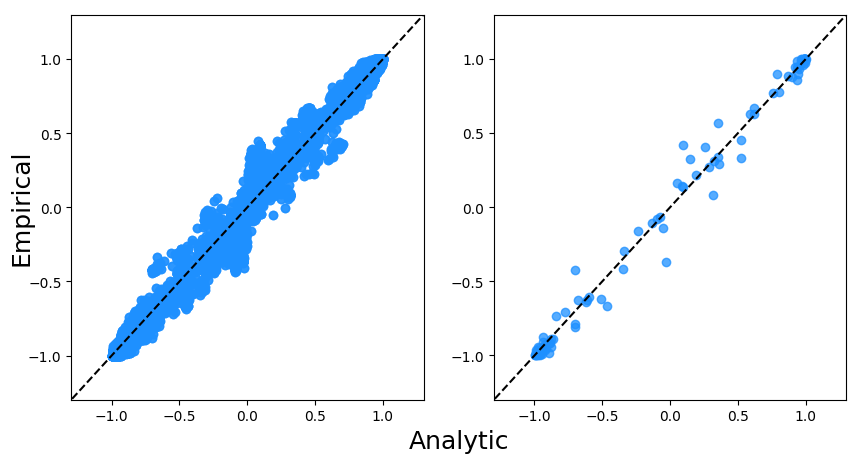

In [23]:
scatter_color = "dodgerblue"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].scatter(anal_obs["chi"], emp_obs["chi"], color=scatter_color, alpha=0.75)

x = np.linspace(anal_obs["chi"].min()-5, anal_obs["chi"].max()+5, 10)
ax[0].plot(x, x, color="black", linestyle="--")

dx = .3
ax[0].set_xlim([anal_obs["chi"].min()-dx, anal_obs["chi"].max()+dx])
ax[0].set_ylim([anal_obs["chi"].min()-dx, anal_obs["chi"].max()+dx])

ax[1].scatter(anal_obs["m"], emp_obs["m"], color=scatter_color, alpha=0.75)

x = np.linspace(anal_obs["m"].min()-5, anal_obs["m"].max()+5, 10)
ax[1].plot(x, x, color="black", linestyle="--")

dx = .3
ax[1].set_xlim([anal_obs["m"].min()-dx, anal_obs["m"].max()+dx])
ax[1].set_ylim([anal_obs["m"].min()-dx, anal_obs["m"].max()+dx])

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Analytic", fontsize=18)
plt.ylabel("Empirical", fontsize=18)

plt.show()


### TO-DO: 
- confirm equation for chi_analytic, and derive equation for m_analytic
- make scatter plots
- plot sensitivity curves

In [63]:
def plot_generalized(layout_spec):
    
    num_rows = max([r for (r,_) in layout_spec.keys()])
    num_cols = max([c for (_,c) in layout_spec.keys()])
    
    fig = make_subplots(rows=num_rows, cols=num_cols, horizontal_spacing=0.1, vertical_spacing=0.1)

    curve_color = 'rgba(250, 150, 0, 1)'
    fill_color = 'rgba(250, 150, 0, 0.5)'


    for (r, c), specs in layout_spec.items():

        data = specs["data"]
        label = specs["label"]
        step_label = specs["step_label"]

        if isinstance(data[0], float):
            steps = list(range(len(data)))
            fig.add_trace(go.Scatter(x=steps, y=data, mode='lines', name=f'{label}', line=dict(color=curve_color)), row=r, col=c)

        else:
            data = [a.flatten() for a in data]

            av_data = np.mean(data, axis=1)
            min_data = np.min(data, axis=1)
            max_data = np.max(data, axis=1)
            steps = list(range(len(av_data)))

            fig.add_trace(go.Scatter(x=steps, y=av_data, mode='lines', name=f'Av. {label}', line=dict(color=curve_color)), row=r, col=c)
            fig.add_trace(go.Scatter(x=steps, y=min_data, mode='lines', line=dict(width=0), hoverinfo='skip'), row=r, col=c)
            fig.add_trace(go.Scatter(x=steps, y=max_data, mode='lines', fill='tonexty', fillcolor=fill_color, line=dict(width=0), hoverinfo='skip'), row=r, col=c)

        fig.update_xaxes(title_text=step_label, row=r, col=c)
        fig.update_yaxes(title_text=label.capitalize(), row=r, col=c)

    fig.update_layout(height=400 * num_rows, width=400 * num_cols, showlegend=False)

    fig.show()
    #display(fig)
